# Representing Data for Training Sequential Networks in Keras
When we use sequential networks, the most common form of data is text. In order to represent a sentence, we will need to make a few decisions. 
- Will our network fundamentally represent characters? Words? What are the building blocks for our structure?
- What is the maximum sequence length? 
- What is my maximum vocabulary size?
- What style of sequence network should I use?
- Can I incorporate an Embedding? What size?
- What is my problem type? Many to one? Many to many? Sequence-to-Sequence?

Let's start with a simple example from the IMdB dataset and see what the representation in Keras should look like for a sequential convolutional neural network.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence


# load the dataset but only keep the top n words, zero the rest
top_words = 1000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

# truncate and pad input sequences to be the same length
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

In [2]:
print(type(X_train), X_train.shape)
print(type(X_train[0]), X_train[0].shape)
print('Vocabulary size:', np.max(X_train))
print(y_train.shape, np.min(y_train), np.max(y_train))
NUM_CLASSES = 1

<class 'numpy.ndarray'> (25000, 500)
<class 'numpy.ndarray'> (500,)
Vocabulary size: 999
(25000,) 0 1


The IMDB ratings data contains: a number of different reviews and the sentiment of the review as positive or negative. 

Metal device set to: Apple M2
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 500, 50)      50000       ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 496, 64)      16064       ['embedding[0][0]']              
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 99, 64)       0           ['conv1d[0][0]']                 
                                                                

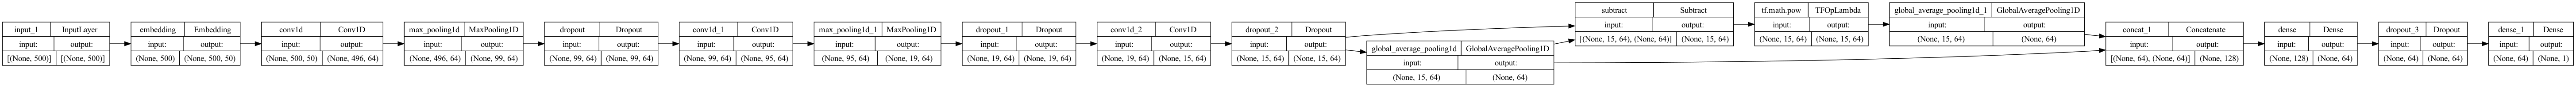

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Embedding, Input, Concatenate
from tensorflow.keras.layers import Subtract
from tensorflow.keras.utils import plot_model
import tensorflow as tf

EMBED_SIZE = 50
# the input is a list of integers, 500 long
sequence_input = Input(shape=(X_train.shape[1], ))

# this will reduce the input dimension from VOCAB_SIZE to 50 for each word
# the lenght will be the maximum number of words in a document, so 500
embedded_sequences = Embedding(top_words, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=max_review_length)(sequence_input) # number of words in each sequence

# starting sequence size is 500 (words) by 50 (embedded features)
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, length becomes: 500-4=496 
# so overall size is 496 by 64

# now pool across time
x = MaxPooling1D(5)(x)# after max pool, 496/5 -> 99 by 64
x = Dropout(0.2)(x)

# extract additional features
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 95 after the conovlutions
x = MaxPooling1D(5)(x) # after max pool, size is 95/5 = 19 by 64
x = Dropout(0.2)(x)

# more features through CNN processing!
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)

# after convolution, size becomes 15 elements long
# Take the mean of these elements across features, result is 64 elements
x_mean = GlobalAveragePooling1D()(x) # this is the size to globally flatten 

# Take the variance of these elements across features, result is 64 elements
x_tmp = Subtract()([x,x_mean])
x_std = GlobalAveragePooling1D()(x_tmp**2)

x = Concatenate(name='concat_1')([x_mean,x_std])

x = Dense(64, activation='relu',
          kernel_initializer='he_uniform')(x)

x = Dropout(0.2)(x)

preds = Dense(NUM_CLASSES, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

model = Model(sequence_input, preds)

print(model.summary())

# you will need to install pydot properly on your machine to get this running
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay


lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.95,
    staircase=True) 
# clipnorm=1.0, 

opt = Adam(epsilon=0.0001, learning_rate=lr_schedule)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['acc'])



In [5]:
%%time 

history = []
tmp = model.fit(X_train, y_train, epochs=5, 
                batch_size=64, 
                validation_data=(X_test, y_test))
history.append( tmp )

Epoch 1/5


2023-10-01 09:45:01.674029: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


391/391 [==============================] - 43s 107ms/step - loss: 0.6284 - acc: 0.6006 - val_loss: 0.4158 - val_acc: 0.8095
Epoch 2/5
391/391 [==============================] - 35s 90ms/step - loss: 0.3603 - acc: 0.8430 - val_loss: 0.3361 - val_acc: 0.8554
Epoch 3/5
391/391 [==============================] - 34s 87ms/step - loss: 0.3090 - acc: 0.8709 - val_loss: 0.3191 - val_acc: 0.8659
Epoch 4/5
391/391 [==============================] - 34s 86ms/step - loss: 0.2820 - acc: 0.8833 - val_loss: 0.3035 - val_acc: 0.8699
Epoch 5/5
391/391 [==============================] - 34s 86ms/step - loss: 0.2487 - acc: 0.8994 - val_loss: 0.2983 - val_acc: 0.8722
CPU times: user 26.9 s, sys: 11.7 s, total: 38.5 s
Wall time: 2min 59s


In [6]:
# run this as many times as we want! Adds 5 epochs each time
tmp = model.fit(X_train, y_train, epochs=5, 
                batch_size=64, 
                validation_data=(X_test, y_test))
history.append( tmp )

Epoch 1/5
391/391 [==============================] - 34s 86ms/step - loss: 0.2097 - acc: 0.9182 - val_loss: 0.3156 - val_acc: 0.8699
Epoch 2/5
391/391 [==============================] - 31s 79ms/step - loss: 0.1805 - acc: 0.9294 - val_loss: 0.3204 - val_acc: 0.8731
Epoch 3/5
391/391 [==============================] - 11s 27ms/step - loss: 0.1442 - acc: 0.9441 - val_loss: 0.3442 - val_acc: 0.8689
Epoch 4/5
391/391 [==============================] - 11s 28ms/step - loss: 0.1152 - acc: 0.9570 - val_loss: 0.4279 - val_acc: 0.8562
Epoch 5/5
391/391 [==============================] - 11s 29ms/step - loss: 0.0969 - acc: 0.9628 - val_loss: 0.4362 - val_acc: 0.8572


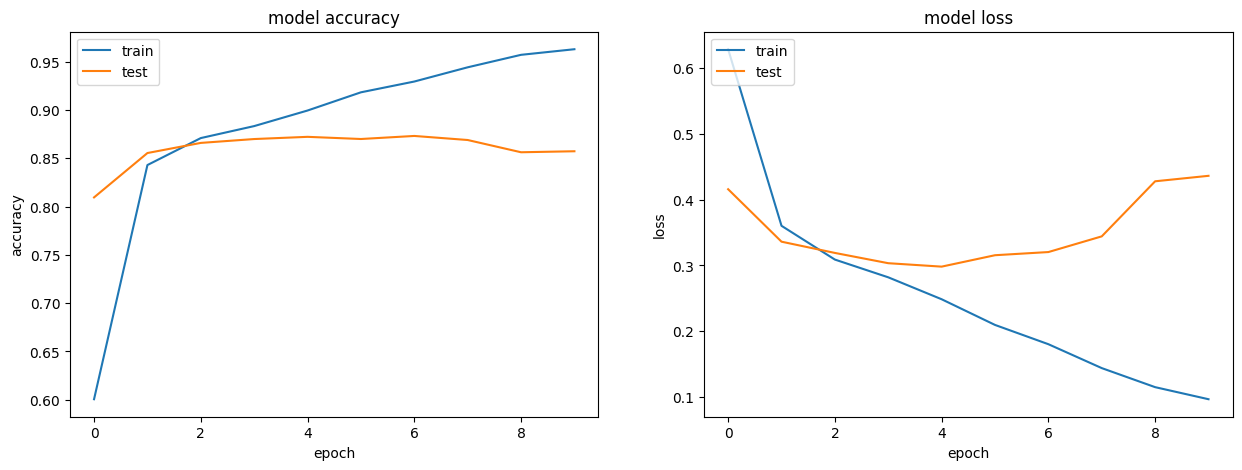

In [7]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Transformers
TODO: explain more on transformers.

Example from the folling: https://keras.io/examples/nlp/text_classification_with_transformer/

In [8]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer

# The transformer architecture 
class TransformerBlock(Layer): # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # setup the model heads and feedforward network
        self.att = MultiHeadAttention(num_heads=num_heads, 
                                      key_dim=embed_dim)
        
        # make a two layer network that processes the attention
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation='relu') )
        self.ffn.add( Dense(embed_dim) )
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        # apply the layers as needed (similar to PyTorch)
        
        # get the attention output from multi heads
        attn_output = self.att(inputs, inputs)
        # create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output)
        # apply dropout if training
        out1 = self.dropout1(out1, training=training)
        # place through feed forward after layer norm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        # apply dropout if training
        out2 = self.dropout2(out2, training=training)
        #return the residual from Dense layer
        return out2
    
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        # create two embeddings 
        # one for processing the tokens (words)
        self.token_emb = Embedding(input_dim=vocab_size, 
                                   output_dim=embed_dim)
        # another embedding for processing the position
        self.pos_emb = Embedding(input_dim=maxlen, 
                                 output_dim=embed_dim)

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [9]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = TokenAndPositionEmbedding(X_train.shape[1], top_words, embed_dim)(inputs)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(20, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(NUM_CLASSES, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

model_xformer = Model(inputs=inputs, outputs=outputs)
print(model_xformer.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500)]             0         
                                                                 
 token_and_position_embeddin  (None, 500, 32)          48000     
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 500, 32)          10656     
 merBlock)                                                       
                                                                 
 global_average_pooling1d_2   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 32)                0   

In [10]:
model_xformer.compile(optimizer='adam', 
                      loss='binary_crossentropy', 
                      metrics=['accuracy'])

history = model_xformer.fit(
    X_train, y_train, batch_size=64, epochs=2, 
    validation_data=(X_test, y_test)
)

Epoch 1/2
391/391 [==============================] - 175s 445ms/step - loss: 0.5993 - accuracy: 0.6333 - val_loss: 0.3731 - val_accuracy: 0.8354
Epoch 2/2
391/391 [==============================] - 171s 437ms/step - loss: 0.3323 - accuracy: 0.8611 - val_loss: 0.3026 - val_accuracy: 0.8712


782/782 [==============================] - 43s 54ms/step


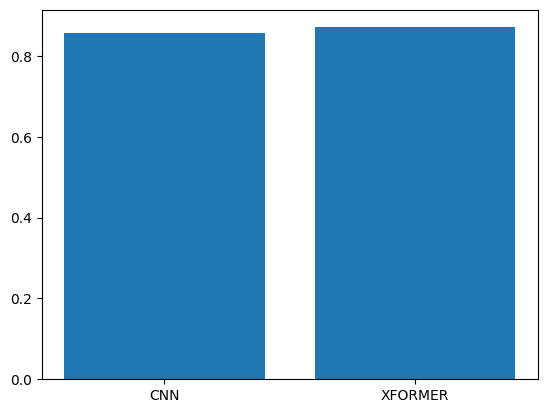

In [11]:

yhat_cnn = model.predict(X_test)
yhat_xformer = model_xformer.predict(X_test)

acc = [mt.accuracy_score(y_test,np.round(yhat_cnn)),
       mt.accuracy_score(y_test,np.round(yhat_xformer)),
      ]

plt.bar([1,2],acc)
plt.xticks([1,2],['CNN','XFORMER'])
plt.show()

_____

# Sequences with Pre-processing in Keras

## Moving to 20 Newsgroups
So we should be able to convert a new dataset into the same format as above. Let's do this from scratch, converting the 20 news groups data. 
- http://qwone.com/~jason/20Newsgroups/

We looked at this a while back when we created the tf-idf and bag-of-words models. This time, we are not going to get rid of the sequence of words for classification. 

In [12]:
# convert 20 newsgroups into keras sequence format
from sklearn.datasets import fetch_20newsgroups
bunch = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)

In [13]:
import numpy as np

# display a random document and label
idx = round(np.random.rand()*len(bunch.data))
print('--------Random Document---------')
print('================================')
print('Document Label: ',bunch.target_names[bunch.target[idx]])
print('================================')
print("\n".join(bunch.data[idx].split("\n")))

--------Random Document---------
Document Label:  talk.religion.misc
From: pharvey@quack.kfu.com (Paul Harvey)
Subject: Re: A KIND and LOVING God!! (NOT!)
Organization: The Duck Pond public unix: +1 408 249 9630, log in as 'guest'.
	<sandvik-150493181533@sandvik-kent.apple.com> 
	<1993Apr16.181605.15072@ra.royalroads.ca> 
	<sandvik-160493205451@sandvik-kent.apple.com>
Lines: 28

In article <sandvik-160493205451@sandvik-kent.apple.com> 
sandvik@newton.apple.com (Kent Sandvik) writes:
>In article <1993Apr16.181605.15072@ra.royalroads.ca>,
>mlee@post.RoyalRoads.ca (Malcolm Lee) wrote:
>> This brings up another question I still have to ponder:  why is there so 
>> much anti-Semitism?  Why do people hate Jews?  I don't hate Jews.  I consider
>> them to be like anyone else, sinners we all are.
>I don't know, I don't care about ethnical rights and wrongs myself,
>but it's evident that Christians consider Jews no longer to be the 
>sole selected group of God's people -- while Jews consider thi

In [14]:
%%time
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_ART_LEN = 1000 # maximum and minimum number of words

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(bunch.data)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(bunch.data)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y_ohe = keras.utils.to_categorical(bunch.target)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Found 134142 unique tokens. Distilled to 134142 top words.
Shape of data tensor: (11314, 1000)
Shape of label tensor: (11314, 20)
134142
CPU times: user 1.76 s, sys: 39.3 ms, total: 1.8 s
Wall time: 1.8 s


So that's it! The representation is now:
- each word is converted to an integer 
- each article is a series of integers that represent the correct ordering of words
- the target is one hot encoded

___

X_train Shape: (9051, 1000) Label Shape: (9051, 20)


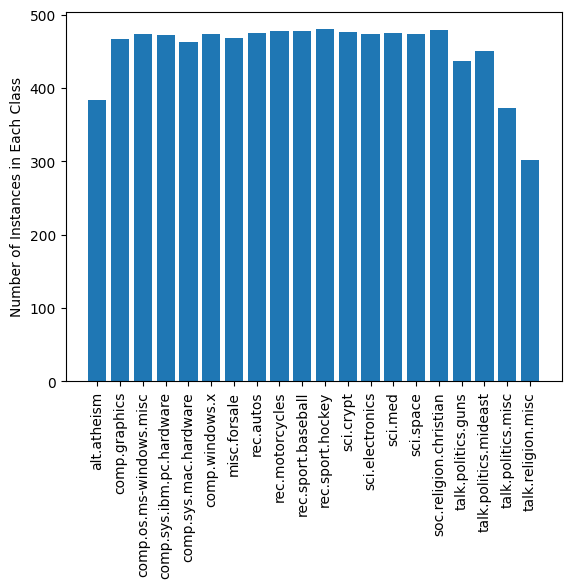

In [15]:
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

# Split it into train / test subsets
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y_ohe, test_size=0.2,
                                                            stratify=bunch.target, 
                                                            random_state=42)
NUM_CLASSES = 20

# print some stats of the data
print("X_train Shape:",X_train.shape, "Label Shape:", y_train_ohe.shape)
uniq_classes = np.sum(y_train_ohe,axis=0)
plt.bar(list(range(20)),uniq_classes)
plt.xticks(list(range(20)), bunch.target_names, rotation='vertical')
plt.ylabel("Number of Instances in Each Class")
plt.show()

## Loading the embedding
But this is going to be a more involved process. Maybe we can speed up the training by loading up a pre-trained embedding of the words?! Recall that the GloVe embedding uses pre-trained word embeddings in order to group contextually similar words together. 

A number of versions of the GloVe embedding matrix are pre-trained using various document. Let's use a version trained from 6B different documents from wikipedia (this is actually one of the smaller datasets trained upon--so the vocabulary might be a bit limited).

Let's use the GloVe word embedding in keras. We will follow the example at:
- https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

You can download the nearly 1GB pretrained embeddings here:
- http://nlp.stanford.edu/data/glove.6B.zip

Let's take a quick look at the format of the file:

In [16]:
!ls -a "large_data/glove/" 

.                   glove.6B.100d.txt   glove.6B.300d.txt   glove.840B.300d.txt
..                  glove.6B.200d.txt   glove.6B.50d.txt


In [17]:
!head "large_data/glove/glove.6B.50d.txt"

the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581
, 0.013441 0.23682 -0.16899 0.40951 0.63812 0.47709 -0.42852 -0.55641 -0.364 -0.23938 0.13001 -0.063734 -0.39575 -0.48162 0.23291 0.090201 -0.13324 0.078639 -0.41634 -0.15428 0.10068 0.48891 0.31226 -0.1252 -0.037512 -1.5179 0.12612 -0.02442 -0.042961 -0.28351 3.5416 -0.11956 -0.014533 -0.1499 0.21864 -0.33412 -0.13872 0.31806 0.70358 0.44858 -0.080262 0.63003 0.32111 -0.46765 0.22786 0.36034 -0.37818 -0.56657 0.044691 0.30392
. 0.15164 0.30177 -0.16763 0.17684 0.31719 0.33973 -0.43478 -0.31086 -0.44999 -0.29486 0.16608 0.11963 -0.41328 -0.42353

In [18]:
%%time
EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('large_data/glove/glove.6B.100d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

Found 400000 word vectors.
Embedding Shape: (134143, 100) 
 Total words found: 56914 
 Percentage: 42.427856839343086
CPU times: user 3.37 s, sys: 195 ms, total: 3.56 s
Wall time: 3.62 s


In [19]:
from tensorflow.keras.layers import Embedding

# save this embedding now
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)



# Start with Convolutional (no std vectors)
Since all the sequences are now the same length, it is possible to construct a convolutional network on top of the embedded sequence outputs. Once embedded, there really is not too much difference in representation about the data and an image (though the data clearly has a different intuition). We will follow these steps:
- use an embedding layer to translate to a dense representation of the entire sequence
- train 1D filters to convolve with the output of the embedded sequence
 - note: 1D filters doesn't mean they are only one dimension, it means the filters are looped through in a single dimension. The size of the filter is [`kernel_size x embed_size`]. It loops through the entire embedding, over a number of words at a time.


In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import Embedding

EMBED_SIZE = 100  # same size as loaded from GLOVE
sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')
# starting size: 1000
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 1000-4=996
x = MaxPooling1D(5)(x)# after max pool, 996/5 = 199
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 195
x = MaxPooling1D(5)(x) # after max pool, size is 195/5 = 39
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# after convolution, size becomes 35 elements long
x = MaxPooling1D(35)(x) # this is the size to globally flatten 
# flattened vector max pools across each of the 35 elements
# so vectors is now 128 dimensions (same as num output filters)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model = Model(sequence_input, preds)

# if representing as OHE, use categorical_crossentropy
# if representing the class as an integer, use sparse_categorical_crossentropy
model.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop',
              metrics=['acc'])

print(model.summary())

histories = []
tmp = model.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
          epochs=2, batch_size=128)
histories.append(tmp)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding_3 (Embedding)     (None, 1000, 100)         13414300  
                                                                 
 conv1d_3 (Conv1D)           (None, 996, 128)          64128     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 199, 128)         0         
 1D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 199, 128)          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 195, 128)          82048     
                                                           

In [21]:
tmp = model.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
                epochs=20, batch_size=128)
histories.append(tmp)

Epoch 1/20
71/71 [==============================] - 4s 61ms/step - loss: 1.9181 - acc: 0.3299 - val_loss: 1.7370 - val_acc: 0.3814
Epoch 2/20
71/71 [==============================] - 4s 61ms/step - loss: 1.6153 - acc: 0.4268 - val_loss: 1.4513 - val_acc: 0.5068
Epoch 3/20
71/71 [==============================] - 4s 60ms/step - loss: 1.3840 - acc: 0.5145 - val_loss: 1.3691 - val_acc: 0.5197
Epoch 4/20
71/71 [==============================] - 4s 62ms/step - loss: 1.2186 - acc: 0.5657 - val_loss: 1.1029 - val_acc: 0.6394
Epoch 5/20
71/71 [==============================] - 4s 60ms/step - loss: 1.0360 - acc: 0.6358 - val_loss: 1.0587 - val_acc: 0.6372
Epoch 6/20
71/71 [==============================] - 4s 60ms/step - loss: 0.9271 - acc: 0.6757 - val_loss: 0.8865 - val_acc: 0.7004
Epoch 7/20
71/71 [==============================] - 4s 60ms/step - loss: 0.8293 - acc: 0.7090 - val_loss: 0.8306 - val_acc: 0.7123
Epoch 8/20
71/71 [==============================] - 4s 60ms/step - loss: 0.7293 - a

In [22]:
tmp = model.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=20, batch_size=128)
histories.append(tmp)

Epoch 1/20
71/71 [==============================] - 5s 69ms/step - loss: 0.1817 - acc: 0.9398 - val_loss: 0.6614 - val_acc: 0.8118
Epoch 2/20
71/71 [==============================] - 5s 77ms/step - loss: 0.1739 - acc: 0.9433 - val_loss: 0.6478 - val_acc: 0.8228
Epoch 3/20
71/71 [==============================] - 6s 85ms/step - loss: 0.1708 - acc: 0.9456 - val_loss: 0.7077 - val_acc: 0.8224
Epoch 4/20
71/71 [==============================] - 6s 88ms/step - loss: 0.1506 - acc: 0.9496 - val_loss: 0.8419 - val_acc: 0.7914
Epoch 5/20
71/71 [==============================] - 6s 88ms/step - loss: 0.1506 - acc: 0.9506 - val_loss: 0.7773 - val_acc: 0.8109
Epoch 6/20
71/71 [==============================] - 7s 96ms/step - loss: 0.1383 - acc: 0.9536 - val_loss: 0.6780 - val_acc: 0.8246
Epoch 7/20
71/71 [==============================] - 7s 93ms/step - loss: 0.1179 - acc: 0.9600 - val_loss: 0.6324 - val_acc: 0.8405
Epoch 8/20
71/71 [==============================] - 7s 98ms/step - loss: 0.1149 - a

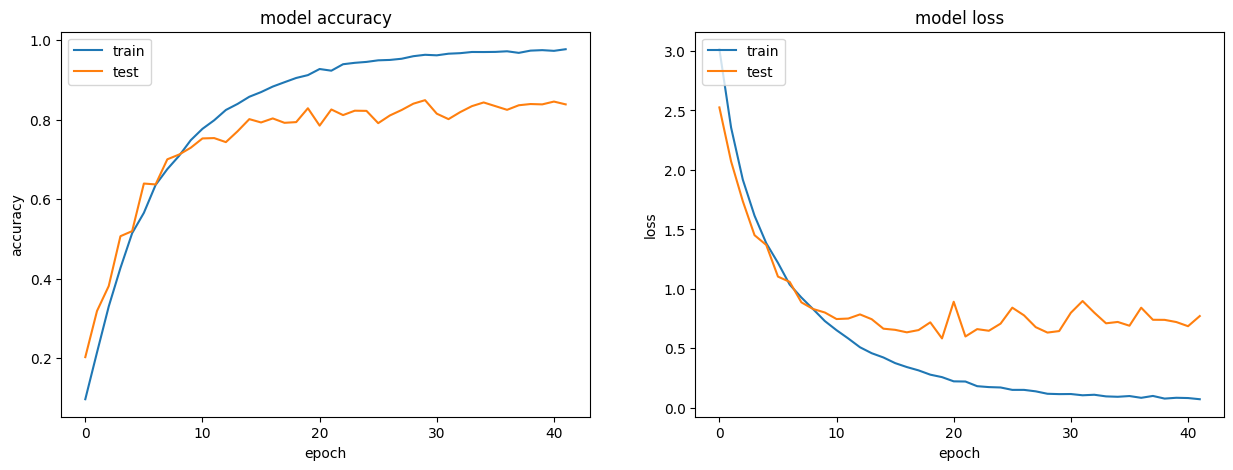

In [23]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Okay. So we seem to be maxing out the performance on the validation set. The results are pretty good--I would expect these to be about a top 10 submission on a class-based Kaggle competition. Nice!
- https://inclass.kaggle.com/c/cs5740-20-newsgroups-classification/leaderboard

# Convolutional with Variance Pooling
TODO: add varinace pooling results on 20 news groups

In [33]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import Embedding

EMBED_SIZE = 100  # same size as loaded from GLOVE
sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')
# starting size: 1000
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 1000-4=996
x = MaxPooling1D(5)(x)# after max pool, 996/5 = 199
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 195
x = MaxPooling1D(5)(x) # after max pool, size is 195/5 = 39
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# after convolution, size becomes 15 elements long
# Take the mean of these elements across features, result is 128 elements
x_mean = GlobalAveragePooling1D()(x) # this is the size to globally flatten 

# Take the variance of these elements across features, result is 128 elements
x_tmp = Subtract()([x,x_mean])
x_std = GlobalAveragePooling1D()(x_tmp**2)

x = Concatenate(name='concat_1')([x_mean,x_std])


x = Dense(128, activation='relu',
          kernel_initializer='he_uniform')(x)

x = Dropout(0.2)(x)

preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_xvec = Model(sequence_input, preds)

# if representing as OHE, use categorical_crossentropy
# if representing the class as an integer, use sparse_categorical_crossentropy
model_xvec.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop',
              metrics=['acc'])

print(model_xvec.summary())

histories = []
tmp = model_xvec.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
          epochs=2, batch_size=128)
histories.append(tmp)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 1000, 100)    13414300    ['input_6[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 996, 128)     64128       ['embedding_3[1][0]']            
                                                                                                  
 max_pooling1d_5 (MaxPooling1D)  (None, 199, 128)    0           ['conv1d_6[0][0]']               
                                                                                            

In [35]:
tmp = model_xvec.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=20, batch_size=128)
histories.append(tmp)

Epoch 1/20
71/71 [==============================] - 4s 62ms/step - loss: 0.2354 - acc: 0.9240 - val_loss: 0.6575 - val_acc: 0.8140
Epoch 2/20
71/71 [==============================] - 4s 61ms/step - loss: 0.2065 - acc: 0.9334 - val_loss: 1.0458 - val_acc: 0.7583
Epoch 3/20
71/71 [==============================] - 4s 61ms/step - loss: 0.2053 - acc: 0.9359 - val_loss: 1.2354 - val_acc: 0.7287
Epoch 4/20
71/71 [==============================] - 4s 61ms/step - loss: 0.1971 - acc: 0.9360 - val_loss: 0.7341 - val_acc: 0.8162
Epoch 5/20
71/71 [==============================] - 4s 61ms/step - loss: 0.1769 - acc: 0.9441 - val_loss: 0.7792 - val_acc: 0.8157
Epoch 6/20
71/71 [==============================] - 4s 61ms/step - loss: 0.1757 - acc: 0.9490 - val_loss: 0.6404 - val_acc: 0.8378
Epoch 7/20
71/71 [==============================] - 4s 61ms/step - loss: 0.1520 - acc: 0.9535 - val_loss: 0.6350 - val_acc: 0.8418
Epoch 8/20
71/71 [==============================] - 4s 61ms/step - loss: 0.1462 - a

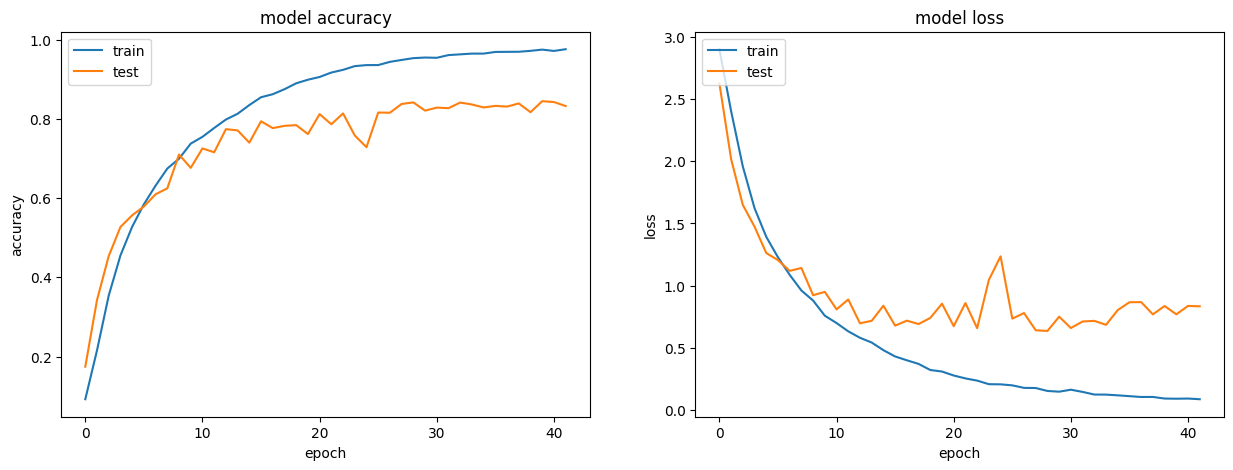

In [36]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Transformer, 20 News Groups
Now lets run the same experiment with a transformer architecture. 

In [24]:
# first, let's replace the original embedding in the xformer
# with our custom GloVe embedding

class GloveTokenAndPositionEmbedding(Layer):
    def __init__(self):
        super().__init__()
        # create two embeddings 
        # one for processing the tokens, pretrained (words)
        self.token_emb = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)
        
        # another embedding for processing the position
        self.pos_emb = Embedding(MAX_ART_LEN, 
                                 EMBED_SIZE, 
                                 input_length=MAX_ART_LEN,
                                 trainable=True
                                )

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [25]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_xformer20 = Model(inputs=inputs, outputs=preds)
print(model_xformer20.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1000)]            0         
                                                                 
 glove_token_and_position_em  (None, 1000, 100)        13514300  
 bedding (GloveTokenAndPosit                                     
 ionEmbedding)                                                   
                                                                 
 transformer_block_1 (Transf  (None, 1000, 100)        168232    
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_3   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_13 (Dropout)        (None, 100)               0   

In [26]:
model_xformer20.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop',
              metrics=['acc'])
histories = []
tmp = model_xformer20.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=6, batch_size=16)
histories.append(tmp)

Epoch 1/6
566/566 [==============================] - 465s 818ms/step - loss: 2.0154 - acc: 0.3530 - val_loss: 1.1482 - val_acc: 0.6372
Epoch 2/6
566/566 [==============================] - 479s 845ms/step - loss: 1.1036 - acc: 0.6446 - val_loss: 0.9828 - val_acc: 0.6814
Epoch 3/6
566/566 [==============================] - 486s 858ms/step - loss: 0.9112 - acc: 0.7143 - val_loss: 0.8833 - val_acc: 0.7274
Epoch 4/6
566/566 [==============================] - 533s 941ms/step - loss: 0.7791 - acc: 0.7484 - val_loss: 0.8442 - val_acc: 0.7477
Epoch 5/6
566/566 [==============================] - 538s 950ms/step - loss: 0.6896 - acc: 0.7830 - val_loss: 0.8326 - val_acc: 0.7419
Epoch 6/6
566/566 [==============================] - 536s 945ms/step - loss: 0.6181 - acc: 0.8017 - val_loss: 0.8152 - val_acc: 0.7583


In [27]:
%%time 

tmp = model_xformer20.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=8, batch_size=16)
histories.append(tmp)

Epoch 1/8
566/566 [==============================] - 549s 970ms/step - loss: 0.5533 - acc: 0.8216 - val_loss: 0.8129 - val_acc: 0.7605
Epoch 2/8
566/566 [==============================] - 533s 940ms/step - loss: 0.5089 - acc: 0.8369 - val_loss: 0.9298 - val_acc: 0.7556
Epoch 3/8
566/566 [==============================] - 487s 860ms/step - loss: 0.4615 - acc: 0.8535 - val_loss: 0.9082 - val_acc: 0.7415
Epoch 4/8
566/566 [==============================] - 446s 788ms/step - loss: 0.4248 - acc: 0.8662 - val_loss: 0.9459 - val_acc: 0.7490
Epoch 5/8
566/566 [==============================] - 439s 776ms/step - loss: 0.3960 - acc: 0.8732 - val_loss: 0.8913 - val_acc: 0.7631
Epoch 6/8
566/566 [==============================] - 478s 844ms/step - loss: 0.3524 - acc: 0.8879 - val_loss: 0.9898 - val_acc: 0.7530
Epoch 7/8
566/566 [==============================] - 482s 851ms/step - loss: 0.3175 - acc: 0.8967 - val_loss: 1.1232 - val_acc: 0.7490
Epoch 8/8
566/566 [==============================] - 47

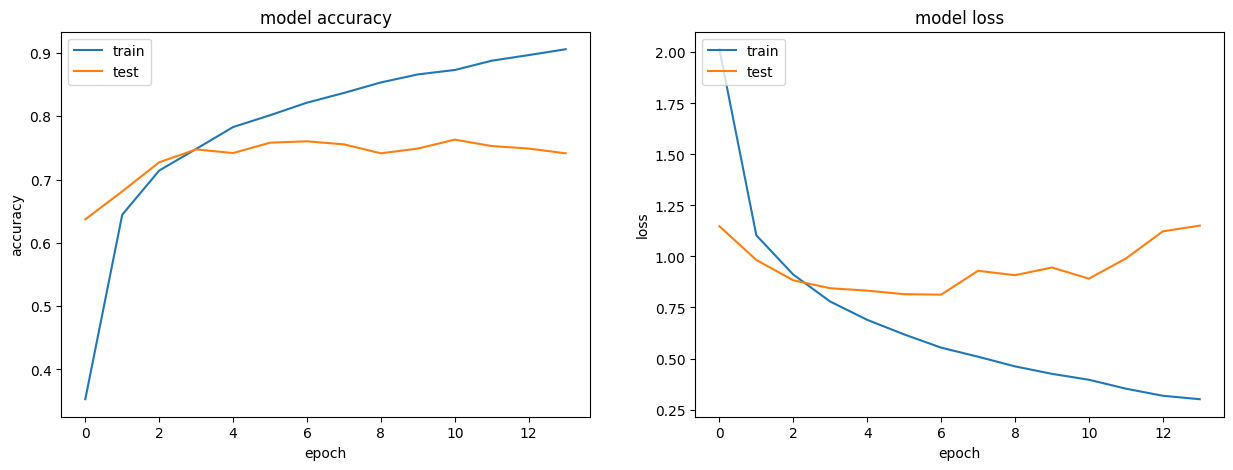

In [28]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Transformer More Layers!!

In [29]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_xformer20 = Model(inputs=inputs, outputs=preds)
print(model_xformer20.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1000)]            0         
                                                                 
 glove_token_and_position_em  (None, 1000, 100)        13514300  
 bedding_1 (GloveTokenAndPos                                     
 itionEmbedding)                                                 
                                                                 
 transformer_block_2 (Transf  (None, 1000, 100)        168232    
 ormerBlock)                                                     
                                                                 
 transformer_block_3 (Transf  (None, 1000, 100)        168232    
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_4   (None, 100)              0   

In [30]:
model_xformer20.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop',
              metrics=['acc'])
histories = []
tmp = model_xformer20.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=6, batch_size=16)
histories.append(tmp)

Epoch 1/6
566/566 [==============================] - 1049s 2s/step - loss: 2.1491 - acc: 0.3058 - val_loss: 1.5519 - val_acc: 0.4936
Epoch 2/6
566/566 [==============================] - 1087s 2s/step - loss: 1.2112 - acc: 0.6114 - val_loss: 1.0972 - val_acc: 0.6513
Epoch 3/6
566/566 [==============================] - 1092s 2s/step - loss: 0.9603 - acc: 0.6912 - val_loss: 0.9444 - val_acc: 0.7070
Epoch 4/6
566/566 [==============================] - 1131s 2s/step - loss: 0.8337 - acc: 0.7303 - val_loss: 0.8634 - val_acc: 0.7384
Epoch 5/6
566/566 [==============================] - 1111s 2s/step - loss: 0.7556 - acc: 0.7573 - val_loss: 0.9181 - val_acc: 0.7225
Epoch 6/6
566/566 [==============================] - 1090s 2s/step - loss: 0.6961 - acc: 0.7763 - val_loss: 0.9286 - val_acc: 0.7260


In [31]:
%%time 

tmp = model_xformer20.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=8, batch_size=16)
histories.append(tmp)

Epoch 1/8
566/566 [==============================] - 1136s 2s/step - loss: 0.6445 - acc: 0.7990 - val_loss: 0.8380 - val_acc: 0.7468
Epoch 2/8
566/566 [==============================] - 1126s 2s/step - loss: 0.6117 - acc: 0.8074 - val_loss: 0.8691 - val_acc: 0.7543
Epoch 3/8
566/566 [==============================] - 1139s 2s/step - loss: 0.5486 - acc: 0.8259 - val_loss: 0.9242 - val_acc: 0.7486
Epoch 4/8
566/566 [==============================] - 1136s 2s/step - loss: 0.5133 - acc: 0.8374 - val_loss: 0.8256 - val_acc: 0.7614
Epoch 5/8
566/566 [==============================] - 1134s 2s/step - loss: 0.4875 - acc: 0.8457 - val_loss: 0.8903 - val_acc: 0.7720
Epoch 6/8
566/566 [==============================] - 7629s 13s/step - loss: 0.4594 - acc: 0.8573 - val_loss: 0.8951 - val_acc: 0.7623
Epoch 7/8
566/566 [==============================] - 3525s 6s/step - loss: 0.4246 - acc: 0.8664 - val_loss: 0.8843 - val_acc: 0.7720
Epoch 8/8
566/566 [==============================] - 1041s 2s/step -

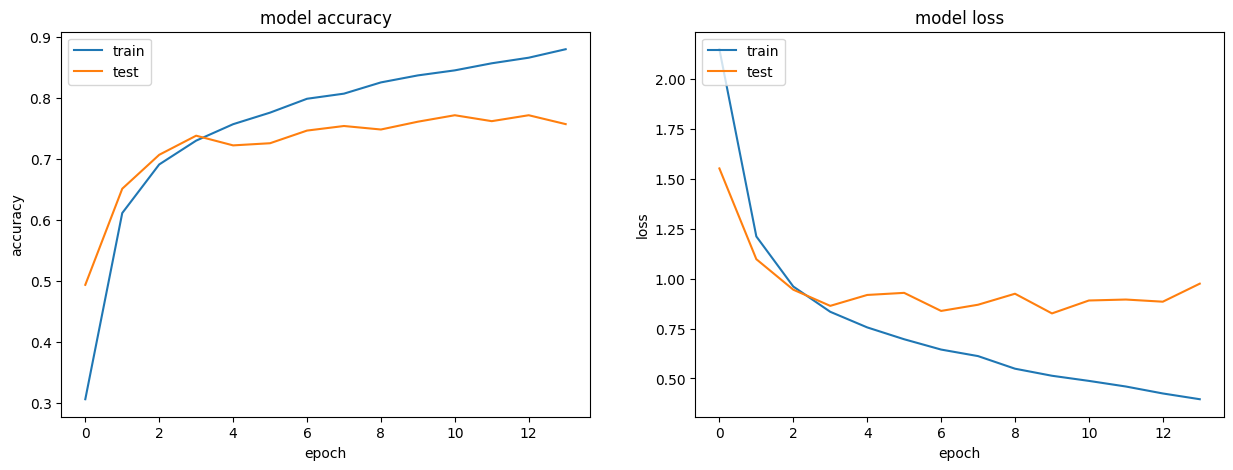

In [32]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()